## Wildfire Smoke Impact on Tourism and Outdoor Recreation
This notebook is used to conduct analysis about the impact of smoke on the tourism industry and recreation in Lewiston. 

## License

The code to obtain the wildfires and filter then by distance was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the Creative Commons CC-BY license

## Imports

In [1]:
import os, json, time
import geojson

import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

## Read data about wildfires within 1250 miles of Lewiston between the years 1963-2020

In [2]:
with open('../data/data_fires_lewiston.json', 'r') as file:
    lewiston_fire = json.load(file)

In [3]:
lewiston_fire[0]

{'OBJECTID': 14299,
 'USGS_Assigned_ID': 14299,
 'Assigned_Fire_Type': 'Wildfire',
 'Fire_Year': 1963,
 'Fire_Polygon_Tier': 1,
 'Fire_Attribute_Tiers': '1 (1), 3 (3)',
 'GIS_Acres': 40992.45827111476,
 'GIS_Hectares': 16589.05930244248,
 'Source_Datasets': 'Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_SubState_MNSRBOPNCA_Wildfires_Historic (1), Comb_SubState_BLM_Idaho_NOC_FPER_Historica_Fire_Polygons (1), Comb_National_BLM_Fire_Perimeters_LADP (1)',
 'Listed_Fire_Types': 'Wildfire (1), Likely Wildfire (3)',
 'Listed_Fire_Names': 'RATTLESNAKE (4)',
 'Listed_Fire_Codes': 'No code provided (4)',
 'Listed_Fire_IDs': '1963-NA-000000 (2)',
 'Listed_Fire_IRWIN_IDs': '',
 'Listed_Fire_Dates': 'Listed Wildfire Discovery Date(s): 1963-08-06 (3) | Listed Wildfire Controlled Date(s): 1963-12-31 (3)',
 'Listed_Fire_Causes': 'Unknown (3)',
 'Listed_Fire_Cause_Class': 'Undetermined (4)',
 'Listed_Rx_Reported_Acres': None,
 'Listed_Map_Digitize_Methods': 'Digitized-Topo (4)',
 'Lis

## Creating the smoke estimate
After going through the attributes of the fires recorded in the [metadata of the USGS dataset](https://www.sciencebase.gov/catalog/file/get/61aa537dd34eb622f699df81?f=__disk__d0%2F63%2F53%2Fd063532049be8e1bc83d1d3047b4df1a5cb56f15&transform=1&allowOpen=true), I believe that an appropriate smoke estimate can be created
from 3 attributes:
1. GIS_Hectares
2. distance
3. Assigned_Fire_Type

**GIS_Hectares** : The GIS calculated hectares of the fire polygon calculated by using the Calculate Geometry tool in ArcGIS Pro.

**distance** : The average miles from the fire boundary to the Lewiston, Idaho.

**Assigned_Fire_Type** : An attribute that can take 5 values

1. Likely Wildfire : The fire was likely a wildfire but there is no way to confirm this.
2. Wildfire : The fire is a confirmed wildfire based on the available attributes.
3. Prescribed Wildfire : The fire is a confirmed prescribed fire based on the available attributes.
4. Unknown - Likely Wildfire : This polygon came from MTBS and was labeled "Unknown". However, research done by Karen Short indicates that the fire is likely a wildfire.
5. Unknown - Likely Prescribed Wildfire : This polygon came from MTBS and was labeled "Unknown". However, research done by Karen Short indicates that the fire is likely a prescribed fire.

The values where the attribute has the word "likely" also leaves room for a scenario where this fire may not have occurred at all. However, when it takes values like "Prescribed Wildfire" and "Wildfire", there is some assurance of 
this fire having occurred. 

Based on this I believe that the values that this attribute takes can be weighted based on assurance of a fire
taking place
1. Likely Wildfire : 15 (The assurance of the wildfire occurring is not given)
2. Wildfire : 20 (assured wildfire)
3. Prescribed Wildfire : 12.5 (assured prescribed wildfire which burns fewer acres than compared to wildfires)
4. Unknown - Likely Wildfire : 20 (research indicates that this is an assured wildfire)
5. Unknown - Likely Prescribed Wildfire : 12.5 (research indicates that this is an assured prescribed wildfire)
6. Other : 1


**smoke_estimate = (GIS_Hectares/distance) * Assigned_Fire_Type_Code**  

**note: the GIS_Hectares is converted to Miles^2 before dividing it by the distance calculated in Miles**

In [4]:
res_smoke = lewiston_fire
# the assigned_fire_type is mapped to numbers that signify the weight that it would give in the smoke estimate
assigned_fire_type_code = {
    'Likely Wildfire': 15,
    'Wildfire': 20,
    'Prescribed Wildfire': 12.5,
    'Unknown - Likely Wildfire': 20,
    'Unknown - Likely Prescribed Wildfire': 12.5
}
for wf_feature in tqdm(res_smoke):
    try:
        fire_type = wf_feature['Assigned_Fire_Type']
        fire_area = wf_feature['GIS_Hectares']/258.998811 #to convert the area to miles^2 
        fire_distance = wf_feature['distance']
    except:
        print("There is a missing attribute")
    if 'Assigned_Fire_Type' in wf_feature:
        if fire_type in assigned_fire_type_code:
            smoke_estimate = (fire_area/fire_distance) * assigned_fire_type_code[fire_type]
        else:
            smoke_estimate = fire_area/fire_distance
        wf_feature['smoke_estimate'] = smoke_estimate

100%|█████████████████████████████████| 78611/78611 [00:00<00:00, 591987.04it/s]


The data obtained above is converted to a dataframe for easier analysis

In [5]:
# extract only the features that are required for analysis and save it in a list: res_mini
res_mini = []
for wf_feature in tqdm(res_smoke):
    mini_feature = {}
    mini_feature['USGS_Assigned_ID'] = wf_feature['USGS_Assigned_ID']
    mini_feature['Assigned_Fire_Type'] = wf_feature['Assigned_Fire_Type']
    mini_feature['Fire_Year'] = wf_feature['Fire_Year']
    mini_feature['GIS_Hectares'] = wf_feature['GIS_Hectares']
    mini_feature['Listed_Fire_Names'] = wf_feature['Listed_Fire_Names']
    mini_feature['distance'] = wf_feature['distance']
    mini_feature['smoke_estimate'] = wf_feature['smoke_estimate']
    res_mini.append(mini_feature)
    
# convert res_mini to a dataframe
df_mini = pd.DataFrame(res_mini)
df_mini.head()

100%|█████████████████████████████████| 78611/78611 [00:00<00:00, 779900.26it/s]


,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Hectares,Listed_Fire_Names,distance,smoke_estimate
0,14299,Wildfire,1963,16589.059302,RATTLESNAKE (4),147.463431,8.686997
1,14300,Wildfire,1963,10423.524591,"McChord Butte (2), No Fire Name Provided (1), ...",132.134128,6.091606
2,14301,Wildfire,1963,18424.208617,"WILLOW CREEK (16), EAST CRANE CREEK (4), Crane...",141.476152,10.056291
3,14302,Wildfire,1963,4206.711433,"SOUTH CANYON CREEK (4), No Fire Name Provided (1)",227.902521,1.425364
4,14303,Wildfire,1963,4040.221900,WEBB CREEK (4),159.883818,1.951340


## Read in Bureau of Labor Statistics Leisure Employment Data

**License:** Custom  

The Bureau of Labor Statistics (BLS) is a Federal government agency and everything that we publish, both in hard copy and electronically, is in the public domain, except for previously copyrighted photographs and illustrations. You are free to use our public domain material without specific permission, although we do ask that you cite the Bureau of Labor Statistics as the source.  

**Description:** This dataset is published by the US Bureau of Labor Statistics. It records employment numbers (in thousands) for each month from 1990 to 2023.  

**Columns:**  

1. Year: the year for which employment numbers are counted
2. January: employment numbers for the month of January for each year
3. February: employment numbers for the month of February for each year
4. March: employment numbers for the month of March for each year
5. April: employment numbers for the month of April for each year
6. May: employment numbers for the month of May for each year
7. June: employment numbers for the month of June for each year
8. July: employment numbers for the month of July for each year
9. August: employment numbers for the month of August for each year
10. September: employment numbers for the month of September for each year
11. October: employment numbers for the month of October for each year
12. November: employment numbers for the month of November for each year
13. December: employment numbers for the month of December for each year


In [6]:
bls_data = pd.read_csv('../data/extension_plan/leisure_bls.csv')
bls_data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1990,2.0,2.1,2.1,2.1,2.1,2.2,2.1,2.2,2.2,2.2,2.2,2.1
1,1991,1.9,1.9,2.0,1.9,1.9,2.0,2.1,2.1,2.1,2.1,2.1,2.0
2,1992,1.9,2.0,2.1,2.1,2.2,2.2,2.2,2.3,2.3,2.3,2.2,2.1
3,1993,2.1,2.1,2.2,2.3,2.3,2.3,2.3,2.4,2.4,2.5,2.4,2.4
4,1994,2.3,2.3,2.4,2.5,2.5,2.6,2.6,2.6,2.6,2.5,2.5,2.4


## Read in the Visitation Data for National Parks in Idaho

**License:** Custom  

The Idaho Department of Parks and Recreation assumes no liability for any loss that may result from the use of this data. The Idaho Department of Parks and Recreation, as a general rule, may modify or delete any of the information that is included in this data without advance notice. The Idaho Department of Parks and Recreation may also interrupt or halt access to this data when deemed necessary. The Idaho Department of Parks and Recreation shall assume no liability for any damages resulting from modification or deletion of this dataset or interruption or halting access to this data.  

**Description:** This dataset is published by the Department of Parks and Recreation of Idaho. The data resides in a small section of the link posted above under the heading: Visitation Statistics. It counts the number of visitation totals representing combined usage between day-use and overnight camping for state parks in Idaho.  

**Columns:**
1. year: the year to match with the visitation number
2. visitation: the visitation number for that year for Idaho state parks 


In [7]:
visitation = pd.read_csv('../data/extension_plan/visitation.csv')
visitation.head()

,year,visitation
0,2014,5300000
1,2015,5000000
2,2016,5400000
3,2017,6000000
4,2018,6400000


## Read in the Data for Airline Arrivals and Delays for Lewiston

**License:** CC-BY  

DOT strongly encourages researchers to deposit data under the Creative Commons CC-BY Attribution or an equivalent license, whenever possible.
The CC-BY license allows others to distribute, remix, tweak, and build upon the work, even commercially, as long as they credit the original creator.
**Description:** This dataset is published by the Bureau of Transportation and contains information about flights that are delayed versus those that are on time. For the purpose of this analysis, I am concerned with the total number of flights arriving at the Lewiston airport and not particularly with delay statistics and causes. Therefore, this dataset can be used for that purpose.  

**Relevant Columns:**  

1. year: the year in which the flight arrived
2. month: the month in which the flight arrived (values range from 1-12)
3. carrier_name: the name of the airline carrier of the flight that arrived at the airport
4. airport: abbreviation of the airport name that the flight arrived at
5. airport_name: full name of the airport that the flight arrived at
6. arr_flights: the total number of flights that arrived at this airport for the specified month and carrier  

Note: There are 15 more columns in this dataset that specify delay causes and the number of minutes of delay. However, since this information is out of the scope and relevance of this study, it will not be used.


In [8]:
airline = pd.read_csv('../data/extension_plan/Airline_Delay_Cause.csv')
airline.head(10)

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",62.0,7.0,3.0,0.0,...,0.0,4.0,0.0,0.0,487.0,196.0,0.0,0.0,0.0,291.0
1,2023,7,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",62.0,8.0,6.0,1.0,...,0.0,1.0,0.0,0.0,521.0,414.0,40.0,0.0,0.0,67.0
2,2023,6,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",60.0,5.0,5.0,0.0,...,0.0,0.0,0.0,0.0,226.0,226.0,0.0,0.0,0.0,0.0
3,2023,5,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",62.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,97.0,97.0,0.0,0.0,0.0,0.0
4,2023,4,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",60.0,6.0,1.0,2.0,...,0.0,3.0,0.0,0.0,249.0,57.0,60.0,0.0,0.0,132.0
5,2023,3,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",62.0,13.0,8.0,3.0,...,0.0,1.0,0.0,0.0,519.0,208.0,162.0,78.0,0.0,71.0
6,2023,2,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",56.0,7.0,3.0,2.0,...,0.0,2.0,0.0,0.0,758.0,65.0,269.0,0.0,0.0,424.0
7,2023,1,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",62.0,14.0,6.0,2.0,...,1.0,5.0,4.0,0.0,630.0,178.0,112.0,0.0,49.0,291.0
8,2022,12,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",62.0,15.0,9.0,3.0,...,0.0,3.0,1.0,1.0,814.0,415.0,214.0,0.0,0.0,185.0
9,2022,11,OO,SkyWest Airlines Inc.,LWS,"Lewiston, ID: Lewiston Nez Perce County",60.0,13.0,10.0,0.0,...,0.0,3.0,0.0,2.0,442.0,310.0,0.0,0.0,0.0,132.0


### Preprocessing airline arrival data to include number of flights and delays due to weather


In [10]:
airline_filtered = airline[['year', 'month', 'arr_flights', 'weather_ct']]
airline_filtered.head()

,year,month,arr_flights,weather_ct
0,2023,8,62.0,0.0
1,2023,7,62.0,1.0
2,2023,6,60.0,0.0
3,2023,5,62.0,0.0
4,2023,4,60.0,2.0


# Analysis

## Research Question 1

How does the Leisure/Hospitality industry in Lewiston, Idaho, respond to heightened levels of smoke in the area? 

### Process:
1. Plot a time series graph of employment in the Leisure/Hospitality industry
2. Plot the smoke estimate time series graph on top of the aforementioned time series graph to compare
3. Calculate the correlation coefficient between the two variables: Employment and Smoke Estimate to understand their association

In [16]:
df_smoke_year = df_mini[['Fire_Year', 'smoke_estimate']]
df_smoke_year.head()

,Fire_Year,smoke_estimate
0,1963,8.686997
1,1963,6.091606
2,1963,10.056291
3,1963,1.425364
4,1963,1.951340


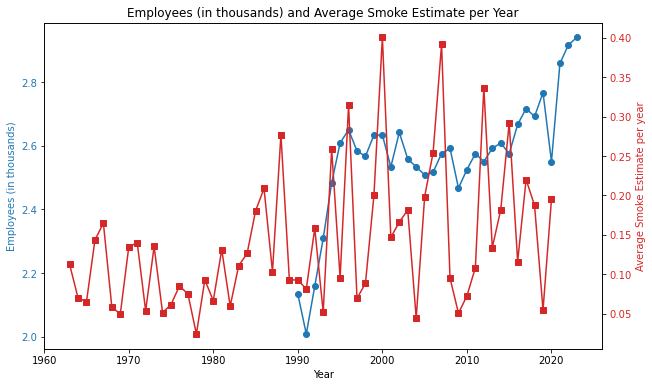

In [17]:
average_smoke_estimate_per_year = df_smoke_year.groupby('Fire_Year')['smoke_estimate'].mean()
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Employees (in thousands)', color=color)
ax1.plot(annual_mean, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the second field
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Smoke Estimate per year', color=color)
ax2.plot(average_smoke_estimate_per_year.index, average_smoke_estimate_per_year.values, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

# Title and show the plot
plt.title('Employees (in thousands) and Average Smoke Estimate per Year')
plt.show()

In [18]:
# Calculating correlation for the two fields : employment change and smoke estimate

# Use the common years to calculate the correlation
common_years = annual_mean.index.intersection(average_smoke_estimate_per_year.index)
correlation = annual_mean[common_years].corr(average_smoke_estimate_per_year[common_years])

print(f'Correlation: {correlation}')

Correlation: 0.25209371033140837


## Results

In general, heightened levels of smoke tend to cause an increase in employment and vice versa but the correlation(0.4597) is weak.

## Research Question 2

Do flights in and out of Lewiston correlate with the amount of smoke in the area?

### Process:
* Create a time series plot with two lines which help compare the smoke estimate over time and flight activity over time.
* Calculate the correlation coefficient between the two variables: average smoke estimate for each year and flight activity

In [19]:
airline_filtered.head()

,year,month,arr_flights,weather_ct
0,2023,8,62.0,0.0
1,2023,7,62.0,1.0
2,2023,6,60.0,0.0
3,2023,5,62.0,0.0
4,2023,4,60.0,2.0


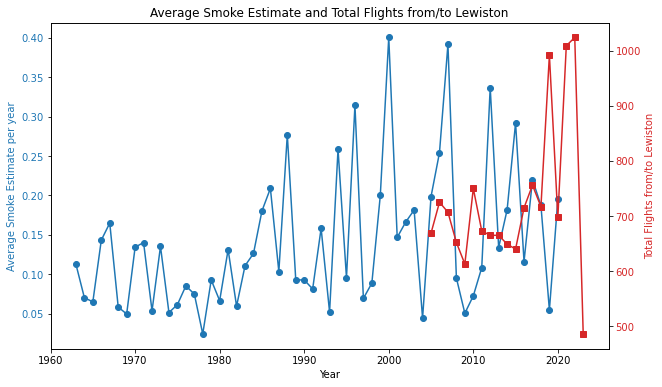

In [49]:
total_flights_per_year = airline_filtered.groupby('year')['arr_flights'].sum()
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Smoke Estimate per year', color=color)
ax1.plot(average_smoke_estimate_per_year, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the second field
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Flights from/to Lewiston', color=color)
ax2.plot(total_flights_per_year.index, total_flights_per_year.values, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

# Title and show the plot
plt.title('Average Smoke Estimate and Total Flights from/to Lewiston')
plt.show()

In [21]:
# Calculating correlation for the two fields : average smoke estimate and total airline weather delays

# Use the common years to calculate the correlation
common_years = total_flights_per_year.index.intersection(average_smoke_estimate_per_year.index)
correlation = total_flights_per_year[common_years].corr(average_smoke_estimate_per_year[common_years])

print(f'Correlation: {correlation}')

Correlation: -0.2398566930100459


## Results
The calculated correlation coefficient of -0.24 and visualization suggests a weak negative correlation between the flight activity and smoke.

## Research Question 3

Is national park visitation in Idaho impacted by smoke?

### Process
* Create a time series plot with two lines which help compare the smoke estimate over time and national park visitation in Idaho over time.
* Calculate the correlation coefficient between the two variables: average smoke estimate for each year and national park visitation

In [22]:
visitation

,year,visitation
0,2014,5300000
1,2015,5000000
2,2016,5400000
3,2017,6000000
4,2018,6400000
5,2019,6500000
6,2020,7700000
7,2021,7500000
8,2022,7000000


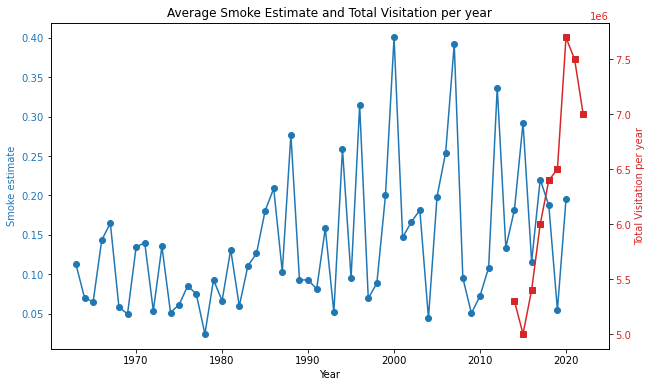

In [23]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first field on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Smoke estimate', color=color)
ax1.plot(average_smoke_estimate_per_year, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the second field
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Visitation per year', color=color)
ax2.plot(visitation['year'], visitation['visitation'], color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)

# Title and show the plot
plt.title('Average Smoke Estimate and Total Visitation per year')
plt.show()

In [24]:
average_smoke_estimate_per_year_df = average_smoke_estimate_per_year.to_frame(name='average_smoke_estimate_per_year_df')
average_smoke_estimate_per_year_df = average_smoke_estimate_per_year_df.reset_index()
average_smoke_estimate_per_year_df.head()

,Fire_Year,average_smoke_estimate_per_year_df
0,1963,0.112721
1,1964,0.070280
2,1965,0.065118
3,1966,0.143371
4,1967,0.164985


In [25]:
visitation.head()


,year,visitation
0,2014,5300000
1,2015,5000000
2,2016,5400000
3,2017,6000000
4,2018,6400000


In [26]:
# merge data on year on both sides to calculate the correlation coefficient
merged_data = pd.merge(visitation, average_smoke_estimate_per_year_df, left_on='year', right_on='Fire_Year')
merged_data.head()


,year,visitation,Fire_Year,average_smoke_estimate_per_year_df
0,2014,5300000,2014,0.181820
1,2015,5000000,2015,0.292009
2,2016,5400000,2016,0.116169
3,2017,6000000,2017,0.220216
4,2018,6400000,2018,0.187287


In [27]:
# Calculating correlation for the two fields : average smoke estimate and total airline weather delays
# Use the common years to calculate the correlation
correlation = merged_data['visitation'].corr(merged_data['average_smoke_estimate_per_year_df'])

print(f'Correlation: {correlation}')


Correlation: -0.25881771880496957


## Results

The park visitation seemed to decrease with an increase in smoke and vice versa but the correlation(-0.26) between the variables is weak.

# Linear Regression Modeling to Predict Tourism Impact


Based on the above graphs and calculated correlation coefficients, I can conclude that there is definitely some association between the smoke estimate and tourism or outdoor recreation in Lewiston, Idaho. 


Based on the calculated correlation coefficients, I can see that all are weakly correlated with the smoke estimate:
1. Employment in the Leisure/Hospitality industry and the Smoke Estimate: 0.25
2. Flight Activity and the Smoke Estimate: -0.24
3. National Park Visitation in Idaho and the Smoke Estimate: -0.26

I want to create 3 separate models:
1. employment_in_the_leisure_industry ~ B0 + B1 * smoke_estimate
2. flight_activity ~ B0 + B1 * smoke_estimate
3. park_visitation ~ B0 + B1 * smoke_estimate

Creating these models would help calculate and extract the beta coefficients of smoke_estimate which is helpful in understanding the association between wildfire smokes and tourism indicators.





## Model 1: employment_in_the_leisure_industry ~ B0 + B1 * smoke_estimate

In [28]:
# have a look at the employment data format
bls_data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1990,2.0,2.1,2.1,2.1,2.1,2.2,2.1,2.2,2.2,2.2,2.2,2.1
1991,1.9,1.9,2.0,1.9,1.9,2.0,2.1,2.1,2.1,2.1,2.1,2.0
1992,1.9,2.0,2.1,2.1,2.2,2.2,2.2,2.3,2.3,2.3,2.2,2.1
1993,2.1,2.1,2.2,2.3,2.3,2.3,2.3,2.4,2.4,2.5,2.4,2.4
1994,2.3,2.3,2.4,2.5,2.5,2.6,2.6,2.6,2.6,2.5,2.5,2.4


In [29]:
# avergae smoke per year calculated above
average_smoke_estimate_per_year_df.head()

,Fire_Year,average_smoke_estimate_per_year_df
0,1963,0.112721
1,1964,0.070280
2,1965,0.065118
3,1966,0.143371
4,1967,0.164985


In [30]:
# convert the bls data to include an average of all months as the yearly employment number
bls_data_copy = bls_data
bls_data_copy['Annual_Average'] = bls_data_copy.mean(axis=1)

In [31]:
# preprocess and format
bls_data_copy = bls_data_copy.reset_index()
bls_data_copy = bls_data_copy[['Year', 'Annual_Average']]
bls_data_copy.head()

,Year,Annual_Average
0,1990,2.133333
1,1991,2.008333
2,1992,2.158333
3,1993,2.308333
4,1994,2.483333


In [32]:
# include employment data only until 2020 as that is year till which we have smoke estimate data
bls_data_copy_2020 = bls_data_copy[bls_data_copy['Year'] <= 2020]
len(bls_data_copy_2020)

31

In [33]:
## extract years 1990 to 2023 for the smoke estimate data
average_smoke_estimate_per_year_df_1990 = average_smoke_estimate_per_year_df[average_smoke_estimate_per_year_df['Fire_Year'] >= 1990]
average_smoke_estimate_per_year_df_1990.head()

,Fire_Year,average_smoke_estimate_per_year_df
27,1990,0.092833
28,1991,0.081452
29,1992,0.158361
30,1993,0.052074
31,1994,0.258614


In [34]:
len(average_smoke_estimate_per_year_df_1990)

31

Since I'm performing a Linear Regression on the predictors: Employment and Smoke Estimate, I want to normalize the two variables via minmax scaling as they are measured in different scales

The MinMaxScaler from sklearn.preprocessing is used to perform this

In [35]:
# import numpy
import numpy as np
# convert the series to a list
employment = bls_data_copy_2020['Annual_Average'].to_list()
smoke_estimate_list = average_smoke_estimate_per_year_df_1990['average_smoke_estimate_per_year_df'].to_list()
# reshape the list to a 2d array to apply the scaler
employment = np.array(employment).reshape(-1, 1)
smoke_estimate_list = np.array(smoke_estimate_list).reshape(-1, 1)

In [36]:
# import the scaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# create scaler instances
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

# apply the scaler to the data
employment_scaled = scaler1.fit_transform(employment)
smoke_estimate_scaled = scaler2.fit_transform(smoke_estimate_list)

In [44]:
# reshape after being scaled to format it
employment_scaled = employment_scaled.reshape(-1, 1)
smoke_estimate_scaled = smoke_estimate_scaled.reshape(-1, 1)

In [45]:
# import the linear regression module
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Fit the model with the scaled features and target values
model.fit(smoke_estimate_scaled, employment_scaled)

# Make predictions using the scaled features
predictions = model.predict(smoke_estimate_scaled)

# Print the coefficients and intercept of the model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [[0.19687045]]
Intercept: [0.62230155]


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(employment_scaled, predictions)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(employment_scaled, predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate R-squared
r2 = r2_score(employment_scaled, predictions)
print(f'R-squared: {r2:.2f}')

Mean Squared Error (MSE): 0.04
Mean Absolute Error (MAE): 0.14
R-squared: 0.06


## Model 2: flight_activity ~ B0 + B1 * smoke_estimate

In [56]:
# viewing the flight data
total_flights_per_year

year
2005     669.0
2006     725.0
2007     707.0
2008     652.0
2009     613.0
2010     750.0
2011     673.0
2012     665.0
2013     665.0
2014     649.0
2015     640.0
2016     715.0
2017     756.0
2018     717.0
2019     992.0
2020     698.0
2021    1009.0
2022    1024.0
2023     486.0
Name: arr_flights, dtype: float64

In [74]:
# since there is only flight data from 2005, I will filter out smoke estimates that are before 2005
average_smoke_estimate_per_year_df_2005 = average_smoke_estimate_per_year_df[average_smoke_estimate_per_year_df['Fire_Year'] >= 2005]
smoke_estimate = average_smoke_estimate_per_year_df_2005['average_smoke_estimate_per_year_df'].to_list()
smoke_estimate = np.array(smoke_estimate).reshape(-1, 1)
len(smoke_estimate)

16

Since there are only 16 values of the smoke estimate, that is from 2005 to 2020, the flight activity would also be trimmed to only include 16 values.

In [62]:
# convert the array to a dataframe
total_flights_per_year_df = total_flights_per_year.to_frame(name='total_flights_per_year')
total_flights_per_year_df = total_flights_per_year_df.reset_index()
total_flights_per_year_df.head()

,year,total_flights_per_year
0,2005,669.0
1,2006,725.0
2,2007,707.0
3,2008,652.0
4,2009,613.0


In [75]:
# filter the total flights activity dataframe to only include rows from 2005 to 2023
total_flights_per_year_df_2020 = total_flights_per_year_df[total_flights_per_year_df['year'] <= 2020]
# convert the series to a list
flight_activity = total_flights_per_year_df_2020['total_flights_per_year'].to_list()
# reshape it to create a 2d array
flight_activity = np.array(flight_activity).reshape(-1, 1)

# scale the values for more meaningful modeling
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
flight_activity_scaled = scaler1.fit_transform(flight_activity)
smoke_estimate_scaled = scaler2.fit_transform(smoke_estimate)

# reshape it to create a 2d array
flight_activity_scaled = np.array(flight_activity_scaled).reshape(-1, 1)
smoke_estimate_scaled = np.array(smoke_estimate_scaled).reshape(-1, 1)


In [78]:
# Create a linear regression model
model2 = LinearRegression()

# Fit the model with the scaled features and target values
model2.fit(smoke_estimate_scaled, flight_activity_scaled)

# Make predictions using the scaled features
predictions2 = model2.predict(smoke_estimate_scaled)

# Print the coefficients and intercept of the model
print("Coefficients:", model2.coef_)
print("Intercept:", model2.intercept_)

Coefficients: [[-0.18503778]]
Intercept: [0.31426796]


In [80]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(flight_activity_scaled, predictions2)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(flight_activity_scaled, predictions2)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate R-squared
r2 = r2_score(flight_activity_scaled, predictions2)
print(f'R-squared: {r2:.2f}')

Mean Squared Error (MSE): 0.05
Mean Absolute Error (MAE): 0.14
R-squared: 0.06


### Model 3: park_visitation ~ B0 + B1 * smoke_estimate

In [81]:
# view the merged data of visitation and average smoke estimate for common years
merged_data.head()

,year,visitation,Fire_Year,average_smoke_estimate_per_year_df
0,2014,5300000,2014,0.181820
1,2015,5000000,2015,0.292009
2,2016,5400000,2016,0.116169
3,2017,6000000,2017,0.220216
4,2018,6400000,2018,0.187287


In [83]:
# convert series to list
park_visitation = merged_data['visitation'].to_list()
smoke_estimate = merged_data['average_smoke_estimate_per_year_df'].to_list()

# reshape the data to scale it
park_visitation = np.array(park_visitation).reshape(-1, 1)
smoke_estimate = np.array(smoke_estimate).reshape(-1, 1)

# scale the values for more meaningful modeling
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
# apply the scaler
park_visitation_scaled = scaler1.fit_transform(park_visitation)
smoke_estimate_scaled = scaler2.fit_transform(smoke_estimate)

# reshape the data for it to be an input into the model
park_visitation_scaled = np.array(park_visitation_scaled).reshape(-1, 1)
smoke_estimate_scaled = np.array(smoke_estimate_scaled).reshape(-1, 1)

In [84]:
# Create a linear regression model
model3 = LinearRegression()

# Fit the model with the scaled features and target values
model3.fit(smoke_estimate_scaled, park_visitation_scaled)

# Make predictions using the scaled features
predictions3 = model3.predict(smoke_estimate_scaled)

# Print the coefficients and intercept of the model
print("Coefficients:", model3.coef_)
print("Intercept:", model3.intercept_)

Coefficients: [[-0.27880105]]
Intercept: [0.53132262]


In [86]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(park_visitation_scaled, predictions3)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(park_visitation_scaled, predictions3)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate R-squared
r2 = r2_score(park_visitation_scaled, predictions3)
print(f'R-squared: {r2:.2f}')

Mean Squared Error (MSE): 0.09
Mean Absolute Error (MAE): 0.24
R-squared: 0.07


## Predictions

This section is outlined to use the aforementioned models to predict for future impact in the tourism industry.

In [89]:
# read in the predicted smoke estimate till 2049
with open('predicted_values.json', 'r') as file:
    predicted_smoke_estimate = json.load(file)

In [92]:
# Convert the dictionary to a DataFrame
df_pse = pd.DataFrame(list(predicted_smoke_estimate.items()), columns=['Year', 'Smoke_Estimate'])
df_pse.tail()

,Year,Smoke_Estimate
74,2045,6.665880
75,2046,6.654907
76,2047,6.662065
77,2048,6.653036
78,2049,6.656869


In [96]:
# convert the values in the Year column to int
df_pse['Year'] = df_pse['Year'].astype(int)
# extract the smoke estimate for years 2024-2049
df_test = df_pse[df_pse['Year'] >= 2024]
df_test.head()

,Year,Smoke_Estimate
53,2024,6.890199
54,2025,7.411005
55,2026,6.592535
56,2027,7.076307
57,2028,6.800236


In [97]:
# extract the predicted values into a list to scale them before making predictions
pse_vals = df_test['Smoke_Estimate'].to_list()
pse_vals = np.array(pse_vals).reshape(-1, 1)

# scale the values for more meaningful modeling
scaler1 = MinMaxScaler()
# apply the scaler
pse_vals_scaled = scaler1.fit_transform(pse_vals)

# reshape the data for it to be an input into the model
pse_vals_scaled = np.array(pse_vals_scaled).reshape(-1, 1)

In [98]:
# prediction of employment in the leisure industry with the predicted smoke estimate as the predictor
predictions1_2049 = model.predict(pse_vals_scaled)
# prediction of flight activity with the predicted smoke estimate as the predictor
predictions2_2049 = model2.predict(pse_vals_scaled)
# prediction of park visitation with the predicted smoke estimate as the predictor
predictions3_2049 = model3.predict(pse_vals_scaled)

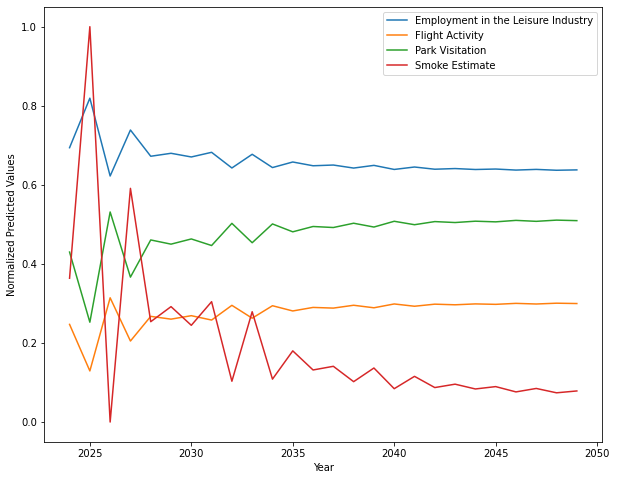

In [110]:
years = np.arange(2024, 2050)

plt.figure(figsize=(10, 8))

# Plot the lines
plt.plot(years, predictions1_2049, label='Employment in the Leisure Industry')
plt.plot(years, predictions2_2049, label='Flight Activity')
plt.plot(years, predictions3_2049, label='Park Visitation')
plt.plot(years, pse_vals_scaled, label = 'Smoke Estimate')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Normalized Predicted Values')
plt.legend()
# Show the plot
plt.show()